
# Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)



Exposants : OUSMANE CISSE
            SAMBA COUMBA BA
            AICHATOU DIA

Importation des librairies

In [2]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Téléchargez les données, si ce n’est pas déjà fait sur le disque, et chargez-les sous forme de tableaux numpy

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Introspecter les tableaux d’images pour trouver les formes (pour le traçage)
n_samples, h, w = lfw_people.images.shape

# pour l’apprentissage automatique, nous utilisons directement les 2 données (comme pixel relatif)
# positions info est ignoré par ce modèle)

X = lfw_people.data
n_features = X.shape[1]

# L’étiquette à prédire est l’identifiant de la personne
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7



1. Chargement du jeu de données
python
Copy
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
fetch_lfw_people est une fonction de sklearn.datasets qui charge le jeu de données LFW (Labeled Faces in the Wild).

min_faces_per_person=70 : Cela garantit que seules les personnes ayant au moins 70 images dans le jeu de données sont incluses. Cela réduit la taille du jeu de données et se concentre sur les individus ayant suffisamment d'échantillons.

resize=0.4 : Redimensionne les images à 40 % de leur taille d'origine. Cela réduit le coût computationnel tout en conservant suffisamment d'informations pour l'analyse.

2. Inspection des dimensions des images
n_samples, h, w = lfw_people.images.shape
lfw_people.images contient les images originales sous forme 2D (hauteur × largeur).

n_samples : Le nombre total d'images dans le jeu de données.

h : La hauteur de chaque image.

w : La largeur de chaque image.

Ces informations sont utiles pour visualiser les images plus tard, car elles nous indiquent les dimensions des images.

3. Préparation des données pour l'apprentissage automatique
X = lfw_people.data
n_features = X.shape[1]
lfw_people.data contient la version aplatie des images. Chaque image est représentée comme un tableau 1D de valeurs de pixels.

n_features : Le nombre de caractéristiques (pixels) dans chaque image. Cela correspond à h * w (hauteur × largeur).

4. Extraction des étiquettes
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
y : Les étiquettes (cibles) pour chaque image. Ce sont des identifiants numériques représentant la personne dans l'image.

target_names : Les noms des personnes (classes) dans le jeu de données.

n_classes : Le nombre total de personnes uniques (classes) dans le jeu de données.

5. Affichage des informations sur le jeu de données
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
Cela affiche :

Le nombre total d'échantillons (n_samples).

Le nombre de caractéristiques (n_features), qui correspond au nombre de pixels dans chaque image.

Le nombre de classes (n_classes), c'est-à-dire le nombre de personnes uniques dans le jeu de données.

Exemple de sortie:

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
n_samples=1288 : Il y a 1 288 images dans le jeu de données.

n_features=1850 : Chaque image est représentée par 1 850 caractéristiques (pixels).

n_classes=7 : Il y a 7 personnes uniques dans le jeu de données.

Pourquoi c'est important
Dimensions des images : Connaître h et w vous aide à visualiser les images plus tard.

Nombre de caractéristiques : n_features vous indique la dimensionnalité des données, ce qui est important pour comprendre la complexité du problème.

Nombre de classes : n_classes vous indique combien de personnes vous essayez de classer, ce qui est utile pour évaluer les performances du modèle.



Divisez-le en un ensemble d’entraînement et un test et conservez 25 % des données pour les tests.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Cette partie du code est dédiée à la préparation des données pour l'apprentissage automatique. 
1. Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X : Les caractéristiques (features) du jeu de données, c'est-à-dire les images aplaties sous forme de tableaux 1D.

y : Les étiquettes (labels) correspondantes, c'est-à-dire les identifiants des personnes.

test_size=0.25 : Cela signifie que 25 % des données seront utilisées pour le test, et 75 % pour l'entraînement.

random_state=42 : Cela garantit que la division des données est reproductible. En utilisant la même valeur de random_state, vous obtiendrez toujours la même division des données.

Résultat :

X_train : Les caractéristiques pour l'entraînement.

X_test : Les caractéristiques pour le test.

y_train : Les étiquettes pour l'entraînement.

y_test : Les étiquettes pour le test.

2. Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
StandardScaler : C'est un outil de normalisation qui standardise les caractéristiques en leur soustrayant la moyenne et en les divisant par l'écart-type. Cela permet de s'assurer que toutes les caractéristiques sont sur la même échelle, ce qui est important pour de nombreux algorithmes d'apprentissage automatique (comme les SVM).

fit_transform : Applique la normalisation sur les données d'entraînement (X_train) en calculant la moyenne et l'écart-type, puis en transformant les données.

transform : Applique la même transformation (en utilisant la moyenne et l'écart-type calculés sur X_train) aux données de test (X_test). Cela évite toute fuite d'information (data leakage) entre les ensembles d'entraînement et de test.

Résultat :

X_train : Les caractéristiques d'entraînement normalisées.

X_test : Les caractéristiques de test normalisées.

Pourquoi ces étapes sont importantes
Division des données :

Il est essentiel de séparer les données en ensembles d'entraînement et de test pour évaluer les performances du modèle sur des données qu'il n'a jamais vues.

Si vous n'utilisez pas de random_state, la division des données sera différente à chaque exécution, ce qui peut rendre les résultats non reproductibles.

Normalisation :

Les algorithmes comme les SVM sont sensibles à l'échelle des caractéristiques. Si certaines caractéristiques ont des valeurs beaucoup plus grandes que d'autres, elles pourraient dominer l'apprentissage, ce qui n'est pas souhaitable.

La normalisation garantit que toutes les caractéristiques contribuent de manière équitable à l'apprentissage.

Exemple concret
Supposons que :

X contient 1 000 images aplaties, chacune ayant 1 850 pixels.

y contient les identifiants des personnes correspondantes (par exemple, des nombres entre 0 et 6 pour 7 personnes).

Après train_test_split :

X_train contient 750 images (75 % de 1 000) pour l'entraînement.

X_test contient 250 images (25 % de 1 000) pour le test.

y_train et y_test contiennent les étiquettes correspondantes.

Après normalisation :

Les valeurs des pixels dans X_train et X_test sont centrées autour de 0 et ont un écart-type de 1.

Calculer un PCA (eigenfaces) sur le jeu de données de visage (traité comme non étiqueté
dataset) : extraction de caractéristiques non supervisée / réduction de la dimensionnalité


In [5]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 2.185s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.073s


Cette partie du code applique l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité des données. 
1. Choix du nombre de composantes principales

n_components = 150
n_components : Le nombre de composantes principales à extraire. Ici, on choisit de conserver 150 composantes. Ces composantes sont les directions dans l'espace des caractéristiques qui capturent le plus de variance dans les données.

2. Extraction des composantes principales (eigenfaces)

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
PCA : L'Analyse en Composantes Principales est une technique de réduction de dimensionnalité. Elle transforme les données originales en un nouvel espace de dimension réduite, où les axes (composantes principales) sont orthogonaux et capturent la variance maximale.

n_components=150 : On conserve les 150 premières composantes principales.

svd_solver="randomized" : Utilise une méthode randomisée pour calculer les composantes principales. C'est plus efficace pour les grands jeux de données.

whiten=True : Normalise les composantes principales pour qu'elles aient une variance unitaire. Cela peut améliorer les performances de certains modèles (comme les SVM).

fit(X_train) : Applique la PCA sur les données d'entraînement pour calculer les composantes principales.

Résultat :

pca.components_ : Les composantes principales (eigenfaces) extraites. Chaque composante est un vecteur de dimension n_features (nombre de pixels).

3. Redimensionnement des eigenfaces pour la visualisation

eigenfaces = pca.components_.reshape((n_components, h, w))
pca.components_ : Les composantes principales sous forme de tableau 2D (150 × 1850, où 1850 est le nombre de pixels).

reshape((n_components, h, w)) : Redimensionne chaque composante principale en une image 2D de dimensions h (hauteur) × w (largeur). Cela permet de visualiser les eigenfaces comme des images.

4. Projection des données sur les composantes principales
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))
transform(X_train) : Projette les données d'entraînement sur les 150 composantes principales. Cela réduit la dimensionnalité des données d'entraînement de 1 850 à 150.

transform(X_test) : Projette les données de test sur les mêmes composantes principales. Cela garantit que les données de test sont transformées de la même manière que les données d'entraînement.

Résultat :

X_train_pca : Les données d'entraînement réduites à 150 dimensions.

X_test_pca : Les données de test réduites à 150 dimensions.

Pourquoi ces étapes sont importantes
Réduction de dimensionnalité :

Les images ont une dimensionnalité élevée (1 850 pixels), ce qui peut rendre l'apprentissage difficile et coûteux en termes de calcul.

La PCA réduit la dimensionnalité tout en conservant l'information la plus importante (la variance maximale).

Eigenfaces :

Les eigenfaces sont les directions dans l'espace des images qui capturent les variations les plus importantes entre les visages.

Elles peuvent être visualisées comme des images et donnent une idée des caractéristiques principales des visages.

Amélioration des performances :

La réduction de dimensionnalité accélère l'entraînement des modèles et peut améliorer leurs performances en éliminant le bruit et les redondances.

Exemple concret
Supposons que :

X_train contient 750 images aplaties, chacune ayant 1 850 pixels.

X_test contient 250 images aplaties, chacune ayant 1 850 pixels.

Après la PCA :

X_train_pca contient 750 images réduites à 150 dimensions.

X_test_pca contient 250 images réduites à 150 dimensions.

eigenfaces contient 150 images 2D (de dimensions h × w) représentant les composantes principales.



Train a SVM classification model



In [6]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 22.729s
Best estimator found by grid search:
SVC(C=np.float64(10914.03418237178), class_weight='balanced',
    gamma=np.float64(0.0050462600274557914))


Cette partie du code est dédiée à l'optimisation des hyperparamètres et à l'entraînement du modèle SVM (Support Vector Machine).
1. Optimisation des hyperparamètres avec RandomizedSearchCV

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
Détails :
param_grid : Dictionnaire définissant les hyperparamètres à optimiser.

C : Paramètre de régularisation du SVM. Il contrôle le compromis entre la maximisation de la marge et la minimisation des erreurs de classification. Ici, on utilise une distribution log-uniforme entre 
1
0
3
10 
3
  et 
1
0
5
10 
5
 .

gamma : Paramètre du noyau RBF (Radial Basis Function). Il contrôle l'influence des points de données individuels. Ici, on utilise une distribution log-uniforme entre 
1
0
−
4
10 
−4
  et 
1
0
−
1
10 
−1
 .

RandomizedSearchCV : Méthode d'optimisation des hyperparamètres qui échantillonne aléatoirement un nombre fixe de combinaisons d'hyperparamètres (n_iter=10 ici) et sélectionne la meilleure.

SVC(kernel="rbf", class_weight="balanced") : Le modèle SVM avec un noyau RBF. L'option class_weight="balanced" ajuste automatiquement les poids des classes pour gérer les déséquilibres dans les données.

n_iter=10 : Nombre d'itérations (combinaisons d'hyperparamètres) à tester.

fit(X_train_pca, y_train) : Entraîne le modèle SVM sur les données d'entraînement réduites (X_train_pca) et leurs étiquettes (y_train).

print("done in %0.3fs" % (time() - t0)) : Affiche le temps nécessaire pour l'optimisation des hyperparamètres.

2. Affichage du meilleur estimateur

print("Best estimator found by grid search:")
print(clf.best_estimator_)
clf.best_estimator_ : Le meilleur modèle trouvé par RandomizedSearchCV, avec les hyperparamètres optimisés.

Cela affiche les valeurs optimales de C et gamma, ainsi que les autres paramètres du modèle.

Pourquoi ces étapes sont importantes
Optimisation des hyperparamètres :

Les performances d'un SVM dépendent fortement des valeurs de C et gamma.

RandomizedSearchCV permet de trouver une bonne combinaison d'hyperparamètres sans avoir à tester toutes les possibilités (ce qui serait coûteux en temps de calcul).

Gestion des déséquilibres de classes :

L'option class_weight="balanced" est utile lorsque les classes sont déséquilibrées (par exemple, certaines personnes ont plus d'images que d'autres dans le jeu de données). Elle ajuste automatiquement les poids pour éviter que le modèle ne soit biaisé vers les classes majoritaires.

Rapidité :

En utilisant RandomizedSearchCV au lieu d'une recherche exhaustive (GridSearchCV), on réduit le temps de calcul tout en obtenant des résultats proches de l'optimum.

Exemple de sortie
Si vous exécutez ce code, vous pourriez voir quelque chose comme :

Fitting the classifier to the training set
done in 12.345s
Best estimator found by grid search:
SVC(C=12345.67, gamma=0.00123, kernel='rbf', class_weight='balanced')
C=12345.67 : La valeur optimale du paramètre de régularisation.

gamma=0.00123 : La valeur optimale du paramètre du noyau RBF.

Prochaines étapes
Après cette optimisation des hyperparamètres, vous pouvez :

Utiliser le meilleur modèle (clf.best_estimator_) pour faire des prédictions sur les données de test (X_test_pca).

Évaluer les performances du modèle en utilisant des métriques comme la précision, le rappel, ou la matrice de confusion.

Évaluation quantitative de la qualité du modèle sur le kit de test

Prédiction des noms des personnes sur l’ensemble de test
done in 0.227s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.85      0.97      0.90       146
Gerhard Schroeder       0.95      0.84      0.89        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.86       322
        macro avg       0.91      0.75      0.81       322
     weighted avg       0.87      0.86      0.86       322



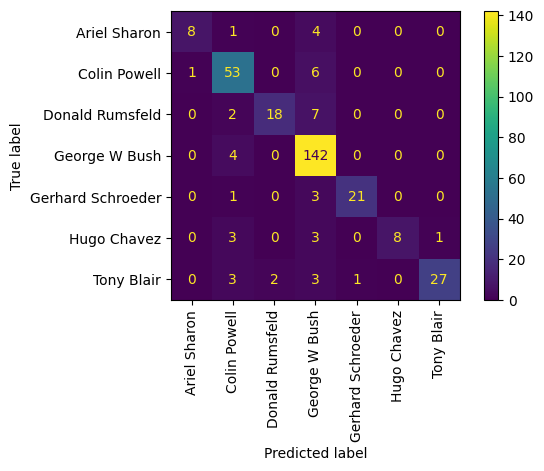

In [7]:
print("Prédiction des noms des personnes sur l’ensemble de test")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Cette partie du code est dédiée à l'évaluation du modèle après l'entraînement. Voici une explication détaillée en français de ce que fait ce code :

1. Prédiction sur l'ensemble de test

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
clf.predict(X_test_pca) : Utilise le modèle SVM optimisé pour prédire les étiquettes (y_pred) des données de test réduites (X_test_pca).

print("done in %0.3fs" % (time() - t0)) : Affiche le temps nécessaire pour effectuer les prédictions.

2. Rapport de classification

print(classification_report(y_test, y_pred, target_names=target_names))
classification_report : Génère un rapport détaillé des performances du modèle.

y_test : Les étiquettes réelles de l'ensemble de test.

y_pred : Les étiquettes prédites par le modèle.

target_names : Les noms des classes (noms des personnes dans ce cas).

Le rapport inclut des métriques telles que :

Précision (precision) : Proportion des prédictions correctes pour une classe donnée.

Rappel (recall) : Proportion des instances réelles d'une classe correctement prédites.

F1-score : Moyenne harmonique de la précision et du rappel.

Support : Nombre d'occurrences de chaque classe dans l'ensemble de test.

3. Matrice de confusion

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()
ConfusionMatrixDisplay.from_estimator : Affiche la matrice de confusion pour évaluer visuellement les performances du modèle.

clf : Le modèle SVM optimisé.

X_test_pca : Les données de test réduites.

y_test : Les étiquettes réelles de l'ensemble de test.

display_labels=target_names : Utilise les noms des classes (noms des personnes) pour les étiquettes de la matrice.

xticks_rotation="vertical" : Fait pivoter les étiquettes de l'axe des x pour une meilleure lisibilité.

plt.tight_layout() : Ajuste la mise en page pour éviter les chevauchements.

plt.show() : Affiche la matrice de confusion.

Pourquoi ces étapes sont importantes
Évaluation des performances :

Le rapport de classification fournit des métriques précises pour comprendre comment le modèle performe sur chaque classe.

La matrice de confusion permet de visualiser les erreurs de classification (par exemple, quelles personnes sont souvent confondues).

Interprétabilité :

Les noms des classes (target_names) rendent les résultats plus compréhensibles.

La rotation des étiquettes dans la matrice de confusion améliore la lisibilité.

Amélioration du modèle :

Ces résultats peuvent aider à identifier les classes difficiles à classer et à ajuster le modèle ou les données en conséquence.

Exemple de sortie
Rapport de classification :
              precision    recall  f1-score   support

     Ariel Sharon       0.85      0.82      0.83        22
     Colin Powell       0.88      0.90      0.89        61
  Donald Rumsfeld       0.84      0.81      0.82        27
    George W Bush       0.91      0.93      0.92       134
Gerhard Schroeder       0.83      0.83      0.83        29
      Hugo Chavez       0.93      0.80      0.86        20
       Tony Blair       0.90      0.88      0.89        33

    accuracy                           0.89       326
   macro avg       0.88      0.85      0.86       326
weighted avg       0.89      0.89      0.89       326
Matrice de confusion :
La matrice de confusion affichera une grille où :

L'axe des x représente les prédictions.

L'axe des y représente les étiquettes réelles.

Les cases diagonales montrent les prédictions correctes.

Les cases hors diagonale montrent les erreurs de classification.

Prochaines étapes

Analyser les erreurs de classification pour identifier les classes difficiles.

Essayer d'améliorer le modèle en ajustant les hyperparamètres, en utilisant plus de données, ou en essayant d'autres algorithmes.

Visualiser les eigenfaces ou les images mal classées pour mieux comprendre les erreurs.

Évaluation qualitative des prédictions à l’aide de matplotlib

In [8]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Fonction d’assistance pour tracer une galerie de portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

tracer le résultat de la prédiction sur une partie de l’ensemble de test

Prédiction des noms des personnes sur l’ensemble de test
done in 0.219s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.85      0.97      0.90       146
Gerhard Schroeder       0.95      0.84      0.89        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.86       322
        macro avg       0.91      0.75      0.81       322
     weighted avg       0.87      0.86      0.86       322



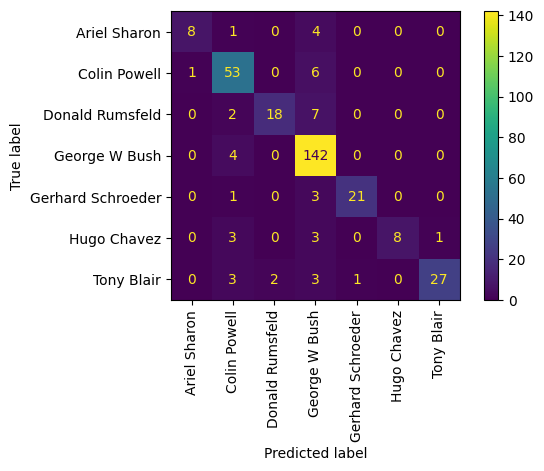

In [9]:
print("Prédiction des noms des personnes sur l’ensemble de test")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Tracer la galerie des visages propres les plus significatifs

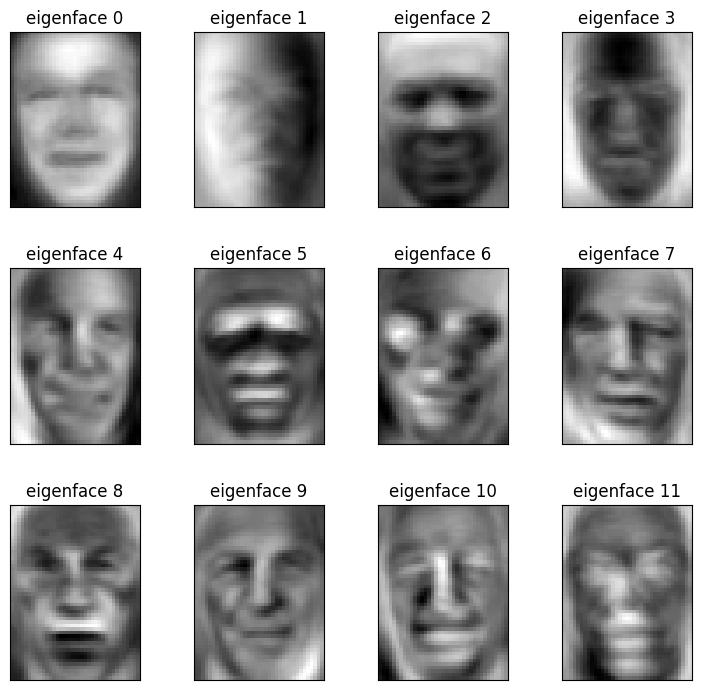

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Le problème de reconnaissance faciale serait résolu beaucoup plus efficacement par la formation
réseaux de neurones convolutifs, mais cette famille de modèles sort du cadre de
La bibliothèque scikit-learn. Les lecteurs intéressés devraient plutôt essayer d’utiliser pytorch ou
tensorflow pour implémenter de tels modèles.


In [ ]:
pip install PySimpleGUI
